<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/tuning_calc/normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preload

In [1]:
from google.colab import drive

from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
! pip install https://github.com/raghakot/keras-vis/archive/master.zip #keras vis

Cloning into 'vgg16obj'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 365 (delta 25), reused 24 (delta 8), pack-reused 307
Receiving objects: 100% (365/365), 6.20 MiB | 4.08 MiB/s, done.
Resolving deltas: 100% (202/202), done.
     \ 57.1MB 2.2MB/s
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30856 sha256=1f63c822e8f1de440db3a71b9fae7942b319fd9bc3ec9839ff71d35c0cdbd261
  Stored in directory: /tmp/pip-ephem-wheel-cache-owsx3hau/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


In [3]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
#!unzip -q /content/drive/My\ Drive/obj/data_6class
!unzip -q /content/drive/My\ Drive/obj/merge


# Snip


In [1]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle
import cv2
import seaborn as sns


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input,BatchNormalization
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st
from vgg16obj.tools import plot_tools as pt


import tensorflow as tf
from tensorflow import math

# Load Images

In [2]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def convertimgs(path,noise = False) :
    data = []
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            if noise:
              im = noisy(im)
            data.append(im) 
    return data

(12, 80, 224, 224, 3) (12, 40, 224, 224, 3)
(12, 80, 224, 224, 3) (12, 40, 224, 224, 3)


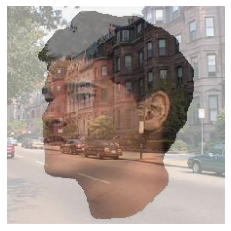

In [3]:
# Merged images load
data_train = [[]  for i in range(12)]
data_train[0] = convertimgs('/content/merge/merge_train/Correct/Male',noise = False)  #75
data_train[1] = convertimgs('/content/merge/merge_train/Correct/Female/',noise = False) #75
data_train[2] = convertimgs('/content/merge/merge_train/Correct/Manmade/',noise = False) #75
data_train[3] = convertimgs('/content/merge/merge_train/Correct/Natural/',noise = False) #75
data_train[4] = convertimgs('/content/merge/merge_train/Correct/Powered',noise = False) #75
data_train[5] = convertimgs('/content/merge/merge_train/Correct/Nonpowered',noise = False) #75

data_train[6] = convertimgs('/content/merge/merge_train/Incorrect/Male',noise = False) #75
data_train[7] = convertimgs('/content/merge/merge_train/Incorrect/Female',noise = False) #75
data_train[8] = convertimgs('/content/merge/merge_train/Incorrect/Manmade',noise = False) #75
data_train[9] = convertimgs('/content/merge/merge_train/Incorrect/Natural',noise = False) #75
data_train[10] = convertimgs('/content/merge/merge_train/Incorrect/Powered',noise = False) #75
data_train[11] = convertimgs('/content/merge/merge_train/Incorrect/Nonpowered',noise = False) #75
data_train = np.array(data_train)
 
data_test = [[]  for i in range(12)]
data_test[0] = convertimgs('/content/merge/merge_test/Correct/Male',noise = False)  #75
data_test[1] = convertimgs('/content/merge/merge_test/Correct/Female/',noise = False) #75
data_test[2] = convertimgs('/content/merge/merge_test/Correct/Manmade/',noise = False) #75
data_test[3] = convertimgs('/content/merge/merge_test/Correct/Natural/',noise = False) #75
data_test[4] = convertimgs('/content/merge/merge_test/Correct/Powered',noise = False) #75
data_test[5] = convertimgs('/content/merge/merge_test/Correct/Nonpowered',noise = False) #75

data_test[6] = convertimgs('/content/merge/merge_test/Incorrect/Male',noise = False) #75
data_test[7] = convertimgs('/content/merge/merge_test/Incorrect/Female',noise = False) #75
data_test[8] = convertimgs('/content/merge/merge_test/Incorrect/Manmade',noise = False) #75
data_test[9] = convertimgs('/content/merge/merge_test/Incorrect/Natural',noise = False) #75
data_test[10] = convertimgs('/content/merge/merge_test/Incorrect/Powered',noise = False) #75
data_test[11] = convertimgs('/content/merge/merge_test/Incorrect/Nonpowered',noise = False) #75
data_test = np.array(data_test)


print(data_train.shape,data_test.shape)

plt.imshow(data_train[0,1])
plt.axis('off')

# Regular Images load

reg_train = [[]  for i in range(12)]
reg_train[0] = convertimgs('/content/merge/merge_reg_train/Correct/Male',noise = False)  # 75
reg_train[1] = convertimgs('/content/merge/merge_reg_train/Correct/Female',noise = False) # 75
reg_train[2] = convertimgs('/content/merge/merge_reg_train/Correct/Manmade',noise = False) # 75
reg_train[3] = convertimgs('/content/merge/merge_reg_train/Correct/Natural/',noise = False) # 75
reg_train[4] = convertimgs('/content/merge/merge_reg_train/Correct/Powered',noise = False) # 75
reg_train[5] = convertimgs('/content/merge/merge_reg_train/Correct/Nonpowered',noise = False) # 75

reg_train[6] = convertimgs('/content/merge/merge_reg_train/Incorrect/Male',noise = False)  # 75
reg_train[7] = convertimgs('/content/merge/merge_reg_train/Incorrect/Female',noise = False) # 75
reg_train[8] = convertimgs('/content/merge/merge_reg_train/Incorrect/Manmade',noise = False) # 75
reg_train[9] = convertimgs('/content/merge/merge_reg_train/Incorrect/Natural/',noise = False) # 75
reg_train[10] = convertimgs('/content/merge/merge_reg_train/Incorrect/Powered',noise = False) # 75
reg_train[11] = convertimgs('/content/merge/merge_reg_train/Incorrect/Nonpowered',noise = False) # 75
reg_train = np.array(reg_train)


reg_test = [[]  for i in range(12)]
reg_test[0] = convertimgs('/content/merge/merge_reg_test/Correct/Male',noise = False)  #75
reg_test[1] = convertimgs('/content/merge/merge_reg_test/Correct/Female/',noise = False) #75
reg_test[2] = convertimgs('/content/merge/merge_reg_test/Correct/Manmade/',noise = False) #75
reg_test[3] = convertimgs('/content/merge/merge_reg_test/Correct/Natural/',noise = False) #75
reg_test[4] = convertimgs('/content/merge/merge_reg_test/Correct/Powered',noise = False) #75
reg_test[5] = convertimgs('/content/merge/merge_reg_test/Correct/Nonpowered',noise = False) #75

reg_test[6] = convertimgs('/content/merge/merge_reg_test/Incorrect/Male',noise = False) #75
reg_test[7] = convertimgs('/content/merge/merge_reg_test/Incorrect/Female',noise = False) #75
reg_test[8] = convertimgs('/content/merge/merge_reg_test/Incorrect/Manmade',noise = False) #75
reg_test[9] = convertimgs('/content/merge/merge_reg_test/Incorrect/Natural',noise = False) #75
reg_test[10] = convertimgs('/content/merge/merge_reg_test/Incorrect/Powered',noise = False) #75
reg_test[11] = convertimgs('/content/merge/merge_reg_test/Incorrect/Nonpowered',noise = False) #75
reg_test = np.array(reg_test)

print(reg_train.shape,reg_test.shape)

# Model

### Old Model

In [4]:
model = VGG16(weights='imagenet',
              include_top=False,
              input_shape = [224,224,3])



categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 6]))
test_it = np.concatenate((reg_test[interest],reg_test[interest + 6]))
print(train_it.shape,test_it.shape)

start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')
epochs = 30

#train_data = np.load('features_train.npy')
ntrain = 80
train_labels = to_categorical([0] * ntrain + [1]*ntrain)


#test_data = np.load('features_test.npy')
ntest = 40
test_labels = to_categorical([0] * ntest + [1]*ntest) 

losses = 'binary_crossentropy'

top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(2, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
top_model.summary()

es = EarlyStopping(monitor='loss', mode='min', verbose=1)


Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 3.0399420261383057
Test Time: 0.4386758804321289
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
top_dense1 (Dense)           (None, 4096)              102764544 
_________________________________________________________________
predictions (Dense)          (None, 2)                 8194      
Total params: 102,772,738
Trainable params: 102,772,738
Non-trainable params: 0
_________________________________________________________________


### New Model

In [ ]:

import tensorflow as tf
def div_norm_2d(x,
                sum_window = [3,3],
                sup_window= [6,6],
                gamma=None,
                beta=None,
                eps=1.0, 
                scope="dn",
                name="dn_out",
                return_mean=False):
  """Applies divisive normalization on CNN feature maps.
    Collect mean and variances on x on a local window across channels. 
    And apply normalization as below:
      x_ = gamma * (x - mean) / sqrt(var + eps) + beta
    Args:
      x: Input tensor, [B, H, W, C].
      sum_window: Summation window size, [H_sum, W_sum].
      sup_window: Suppression window size, [H_sup, W_sup].
      gamma: Scaling parameter.
      beta: Bias parameter.
      eps: Denominator bias.
      return_mean: Whether to also return the computed mean.
    Returns:
      normed: Divisive-normalized variable.
      mean: Mean used for normalization (optional).
    """

  with tf.compat.v1.variable_scope(scope):
    w_sum = tf.ones(sum_window + [1, 1]) / np.prod(np.array(sum_window))
    w_sup = tf.ones(sup_window + [1, 1]) / np.prod(np.array(sum_window))
    x_mean = tf.reduce_mean(x, [3], keepdims=True)
    x_mean = tf.nn.conv2d(x_mean, w_sum, strides=[1, 1, 1, 1], padding='SAME')
    normed = x - x_mean
    x2 = tf.square(normed)
    x2_mean = tf.reduce_mean(x2, [3], keepdims=True)
    x2_mean = tf.nn.conv2d(x2_mean, w_sup, strides=[1, 1, 1, 1], padding='SAME')
    denom = tf.sqrt(x2_mean + eps)
    normed = normed / denom
    if gamma is not None:
      normed *= gamma
    if beta is not None:
      normed += beta
    normed = tf.identity(normed, name=name)
  if return_mean:
    return normed, x_mean
  else:
    return normed

"\nmodel.compile(optimizer= Adam(lr=1e-5),\n              loss='binary_crossentropy',\n              metrics=['accuracy'])\n\n\nhistory = model.fit(x = train_it,  y = train_labels,\n            epochs=30,\n            batch_size=64,\n            verbose = 1, callbacks = [es])\n"

In [ ]:
test_it = np.concatenate((data_test[0],data_test[0 + 6]))
model.evaluate(test_it,test_labels)

3/3 [==============================] - 0s 71ms/step - loss: 1.4074 - accuracy: 0.6250


[1.407422661781311, 0.625]

In [12]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']

acc = np.zeros((2,6))
for imtype in range(2):
  for cat in range(6):

    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 6])) # Train on regular data
    if imtype == 0: # Regular
      test_it = np.concatenate((reg_test[cat],reg_test[cat + 6])) # Test on merged data
    else:
      test_it = np.concatenate((data_test[cat],data_test[cat + 6])) # Test on merged data
    print(train_it.shape,test_it.shape)


    start = time.time()
    train_data = model.predict(train_it) 
    print(f'Train Time: {time.time() - start}')

    start = time.time()
    test_data = model.predict(test_it) 
    print(f'Test Time: {time.time() - start}')

    history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 0, callbacks = [es])

    out = top_model.evaluate(test_data, test_labels)
    acc[imtype,cat] = out[1]
    print(out)

Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.2247769832611084
Test Time: 0.13322901725769043
3/3 [==============================] - 0s 3ms/step - loss: 0.1118 - accuracy: 0.9500
[0.11176387220621109, 0.949999988079071]
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.21932125091552734
Test Time: 0.1359853744506836
3/3 [==============================] - 0s 2ms/step - loss: 0.2859 - accuracy: 0.9250
[0.28592294454574585, 0.925000011920929]
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.22278308868408203
Test Time: 0.13115334510803223
Epoch 00008: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0559 - accuracy: 0.9750
[0.05591615289449692, 0.9750000238418579]
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.22331929206848145
Test Time: 0.13017606735229492
3/3 [==============================] - 0s 2ms/step - loss: 0.0706 - accurac

0.7822916706403097


Text(0, 0.5, 'Δ Accuracy')

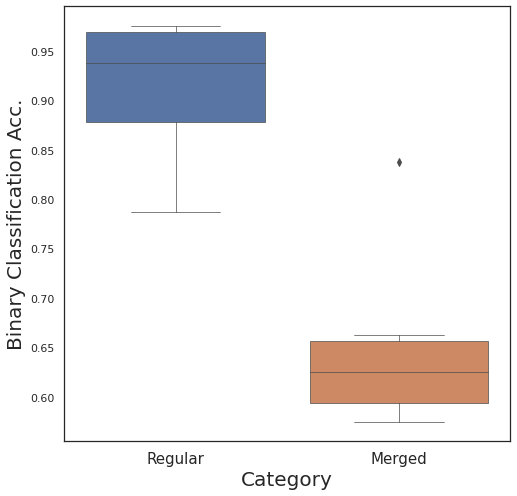

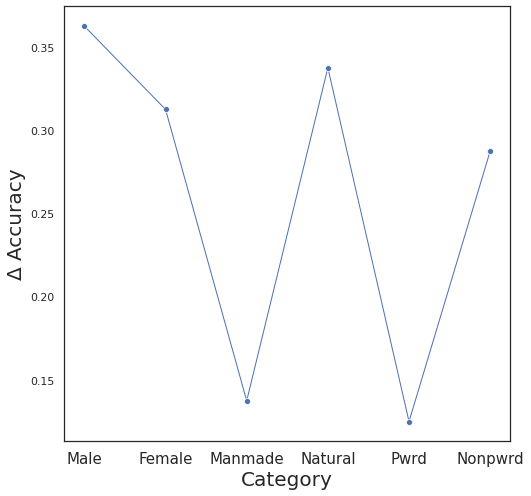

In [13]:
diff = acc[0]-acc[1]
print(np.mean(acc))
import seaborn as sns

sns.set(style="white",rc={"lines.linewidth": 0.7})
plt.figure(figsize = (8,8))
ax = sns.boxplot(data = acc.T )
ax.set_xlabel('Category',size = 20)
ax.set_xticklabels(['Regular','Merged'],size = 15)
ax.set_ylabel('Binary Classification Acc.',size = 20)

# Cateogory wise performance difference
plt.figure(figsize = (8,8))
sns.set(style="white",rc={"lines.linewidth": 1})
ax = sns.lineplot(data = diff ,marker="o")
ax.set_xlabel('Category',size = 20)
ax.set_xticklabels(['Regular','Male','Female','Manmade','Natural','Pwrd','Nonpwrd'],size = 15)
ax.set_ylabel('\u0394 Accuracy',size = 20)



# Tuning Value Calculation

In [ ]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
calc_tun_activ = 0

if calc_tun_activ:
  for cat in range(6): 

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)


    start = time.time()
    tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
    print(f'Elapsed: {time.time() - start}s')

    with open('tuning_values_' + str(cat), 'wb') as fp:
      pickle.dump(tun_activ, fp)



### Load tuning activities

In [5]:
tun_activ = []
for interest in range(6): 
  with open ('/content/tuning_values_5_15_norm' + str(interest), 'rb') as fp:
      tun_activ.extend(pickle.load(fp))
len(tun_activ)



480

### Calculation of tuning values for each map

In [6]:
ncats = 6
# to fish out each category tun_activations
labels = np.array([0] * 40 + [1] * 40 + [2] * 40 + [3] * 40 + [4] * 40 + [5] * 40)
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category, 
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] - 
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]


### Tuning quality

(0.0, 50.0)

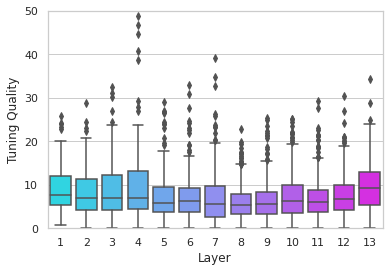

In [7]:
tun_quality = tc.calc_tun_quality(fc)
sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_quality,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,50])

# Attention

### Att

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 10 02:39:43 2020

@author: soukhind
"""
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import relu
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.callbacks import EarlyStopping
from vis.utils import utils
from tensorflow.python.ops import nn
from tensorflow import math
import time
from sklearn.metrics import roc_curve,accuracy_score,precision_recall_curve,f1_score

def gen_attnmap(modifier,mask,category,bi,atype):
    """
    

    Parameters
    ----------
    modifier : list
        modifier to be used to implement attention.
    mask : ndarray
        binary vector to determine which layer to apply attention at. 
        include attention strength by multiplying to it
    category : ndarray
        cateogies .
    bi : boolean 
        bidirectionality
        True & False.
    atype: int
        1 = Multiplicative
        2 = Additive
    Returns
    -------
    tensor_attnmap : tensor
        attention map.

    """
    attnmap = []
    beta = calc_beta(avg_tun_activ)/10
    dist_map = calc_dist_map(category,modifier)
    mod =10
    #conv1_1 & conv1_2
    with tf.compat.v1.variable_scope('mapcal'):
      for layer in range(2):
          stimval = np.float32(modifier[category][layer])
          distval = np.float32(dist_map[category][layer])
          mapval = stimval#/(mod*(distval + 1e-6))
          if bi == False:
              mapval[mapval < 0] = 0
          if atype == 1:
            amap = np.ones((224,224,64),dtype='float32') + np.tile(mapval,[224,224,1])* mask[layer]
          elif atype == 2:
            amap = np.tile(mapval,[224,224,1])* mask[layer]
          #amap[amap < 0] = 0
          attnmap.append(amap)
      
      #conv2_1 & conv2_2
      for layer in range(2,4):
          stimval = np.float32(modifier[category][layer])
          distval = np.float32(dist_map[category][layer])
          mapval = stimval#/(mod*(distval + 1e-6))
          if bi == False:
              mapval[mapval < 0] = 0
          if atype == 1:
            amap = np.ones((112,112,128),dtype='float32') + np.tile(mapval,[112,112,1])* mask[layer]
          elif atype == 2:
            amap = np.tile(mapval,[112,112,1])* mask[layer]
          #amap[amap < 0] = 0
          attnmap.append(amap)
      
      #conv3_1 - conv3_3
      for layer in range(4,7):
          stimval = np.float32(modifier[category][layer])
          distval = np.float32(dist_map[category][layer])
          mapval = stimval#/(mod*(distval + 1e-6))
          if bi == False:
              mapval[mapval < 0] = 0
          if atype == 1:
            amap = np.ones((56,56,256),dtype='float32') + np.tile(mapval,[56,56,1])* mask[layer]
          elif atype == 2:
            amap = np.tile(mapval,[56,56,1])* mask[layer]
          #amap[amap < 0] = 0
          attnmap.append(amap)
      
      #conv4_1 - conv4_3
      for layer in range(7,10):
          stimval = np.float32(modifier[category][layer])
          distval = np.float32(dist_map[category][layer])
          mapval = stimval#/(mod*(distval + 1e-6))
          if bi == False:
              mapval[mapval < 0] = 0
          if atype == 1:
            amap = np.ones((28,28,512),dtype='float32') + np.tile(mapval,[28,28,1])* mask[layer]
          elif atype == 2:
            amap = np.tile(mapval,[28,28,1])* mask[layer]
          #amap[amap < 0] = 0
          attnmap.append(amap)
      
      #conv5_1 - conv5_3
      for layer in range(10,13):
          stimval = np.float32(modifier[category][layer])
          distval = np.float32(dist_map[category][layer])
          mapval = stimval#/(mod*(distval + 1e-6))
          if bi == False:
              mapval[mapval < 0] = 0
          if atype ==1:
            amap = np.ones((14,14,512),dtype='float32') + np.tile(mapval,[14,14,1])* mask[layer]
          elif atype == 2:
            amap = np.tile(mapval,[14,14,1])* mask[layer]
          #amap[amap < 0] = 0
          attnmap.append(amap)
      
      tensor_attnmap = []
      for layer in range(len(attnmap)):
        tensor_attnmap.append(tf.convert_to_tensor(attnmap[layer])) 
    
    return tensor_attnmap



def avg_accuracy(data_train,train_labels,
                 data_test,test_labels,
                 modifier,
                 model,top_model,idxpath,
                 category,
                 atstrng,
                 bidir = True,
                 atype = 1):
    """
    

    Parameters
    ----------
    data_train : ndarray
        Training data.
    train_labels : categorical
        Training labels.
    data_test : ndarray
        Testing data.
    test_labels : categorical
        Testing labels.
    categories : ndarray
        Names of each category.
    modifier : list
        modifier to be used to implement attention.
    model : keras model
        base model.
    top_model : keras model
        top model.
    idxpath : string
        for internal use.
    atstrng : float32
        attention strength.
    bidir : bool, optional
        Bidirectionality. The default is True.
    atype: int
        1 = Multiplicative
        2 = Additive
    Returns
    -------
    t_acc
        Accuracy for each category at each layer.

    """
    
    epochs = 30    
    n_layers = 13
    t_acc = np.zeros(n_layers)
    thr = np.zeros(n_layers)
    for li in range(n_layers):
        layermask = np.zeros(13)
        layermask[li] = 1
        tensor_attnmap = gen_attnmap(modifier,layermask*atstrng,category,bidir,atype)
               
        def attnrelu(x,map = tensor_attnmap,atype = atype):
          with tf.compat.v1.variable_scope('activ'):
              layeridx = np.load(idxpath)
              if layeridx == 2 or 4 or 6 or 8 or 10 or 12:
                x = div_norm_2d(x)
              if layeridx == 13:
                  layeridx = 0
              if atype == 1:
                x = nn.relu(x)
                activations = math.multiply(x,map[layeridx])
              if atype == 2:
                activations = math.add(x,map[layeridx])
                activations = nn.relu(activations)
              layeridx += 1
              np.save(idxpath,layeridx)
              
          return activations
    
        get_custom_objects().update({'attnrelu': Activation(attnrelu)})
    
        for layer in model.layers:
            if(hasattr(layer,'activation')):
                layer.activation = attnrelu
    
        utils.apply_modifications(model)
        model.compile()

        output = model.output
        x = Flatten()(output)
        x = Dense(4096,activation='relu')(x)
        x = Dense(2,activation='softmax')(x)

        new_model = Model(inputs = model.input,outputs= x)
        new_model.compile(optimizer= Adam(lr=1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
        if li == 0:
          new_model.summary()
        #f_train = model.predict(data_train)     
    
        #f_test = model.predict(data_test)
        es = EarlyStopping(monitor='loss', mode='min', verbose=1)
  
        history = new_model.fit(x = data_train,  y = train_labels,
                epochs=epochs,
                batch_size=32,
                verbose = 0, callbacks = [])
    
        out = new_model.evaluate(data_test, test_labels)
        t_acc[li] = out[1]
        tf.keras.backend.clear_session()
        del tensor_attnmap
    return t_acc


def calc_beta(avg_act):
  beta = [0 for item in avg_act]
  for layer in range(len(avg_act)):
    for item in avg_act[layer]:
      beta[layer] += np.mean(item)
      beta = np.array(beta)
  return beta

def calc_dist_map(category,modifer):
  ids = np.array([0,1,2,3,4,5])
  oids = np.where(ids != category)
  omap = [fc[i] for i in oids[0]]
  avg_omap = [[0 for item in subl] for subl in fc[0]] 
  for cat in range(5):
    for layer in range(len(omap[cat])):
      for map in range(len(omap[cat][layer])):
        avg_omap[layer][map] += omap[cat][layer][map]/5
  return avg_omap

def div_norm_2d(x,
                sum_window = [5,5],
                sup_window= [15,15],
                gamma=None,
                beta=None,
                eps=1.0, 
                scope="dn",
                name="dn_out",
                return_mean=False):
  """Applies divisive normalization on CNN feature maps.
    Collect mean and variances on x on a local window across channels. 
    And apply normalization as below:
      x_ = gamma * (x - mean) / sqrt(var + eps) + beta
    Args:
      x: Input tensor, [B, H, W, C].
      sum_window: Summation window size, [H_sum, W_sum].
      sup_window: Suppression window size, [H_sup, W_sup].
      gamma: Scaling parameter.
      beta: Bias parameter.
      eps: Denominator bias.
      return_mean: Whether to also return the computed mean.
    Returns:
      normed: Divisive-normalized variable.
      mean: Mean used for normalization (optional).
    """
  with tf.compat.v1.variable_scope(scope):
    w_sum = tf.ones(sum_window + [1, 1]) / np.prod(np.array(sum_window))
    w_sup = tf.ones(sup_window + [1, 1]) / np.prod(np.array(sum_window))
    x_mean = tf.reduce_mean(x, [3], keepdims=True)
    x_mean = tf.nn.conv2d(x_mean, w_sum, strides=[1, 1, 1, 1], padding='SAME')
    normed = x - x_mean
    x2 = tf.square(normed)
    x2_mean = tf.reduce_mean(x2, [3], keepdims=True)
    x2_mean = tf.nn.conv2d(x2_mean, w_sup, strides=[1, 1, 1, 1], padding='SAME')
    denom = tf.sqrt(x2_mean + eps)
    normed = normed / denom
    del denom,x2_mean,w_sum,w_sup,x_mean,x
    if gamma is not None:
      normed *= gamma
    if beta is not None:
      normed += beta
    normed = tf.identity(normed, name=name)
  if return_mean:
    return normed, x_mean
  else:
    return normed

### Driver

In [10]:
#@title Multiplicative and bidirectionality corrected

from vgg16obj.tools import model_calcs as mc
import gc
layeridx = 0
np.save('layeridx',layeridx)
flag = 1
np.save('flag',flag)
#atstrng = 10.5 #0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10
for atstrng in np.arange(7,10,0.5): #Calling for different attn strengths
  grand_acc = [[] for i in range(6)] 
  for cat in range(6): # Iterating over 6 categories
    tf.keras.backend.clear_session()
    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 6])) # Training on regular data
    test_it = np.concatenate((data_test[cat],data_test[cat + 6])) # Testing on merged data
    print(train_it.shape,test_it.shape)
    model = VGG16(weights='imagenet',
                        include_top=False,input_shape = [224,224,3])
          
    top_model = Sequential()
    top_model.add(Flatten(input_shape=features_train.shape[1:])) 
    top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
    top_model.add(Dense(2, activation='softmax',name = 'predictions'))
    top_model.compile(optimizer= Adam(lr=1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    # Read avg_accuracy's definition to learn about the parameters
    grand_acc[cat] = avg_accuracy(train_it,
                              train_labels,
                              test_it,
                              test_labels,
                              fc,
                              model,
                              top_model,
                              '/content/layeridx.npy',
                              cat,
                              atstrng,
                              bidir = True,
                              atype = 1 )
  grand_acc = np.array(grand_acc)
  grand_acc.reshape([1,6,13])
  # Use tun_accuracy_multi for multiplicative mode (atype = 1) and
  # use tun_accuracy_bias for bias mode (atype = 2)
  np.save('tun_accuracy_multi' + str(atstrng),grand_acc)



Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

ResourceExhaustedError: ignored

In [ ]:
grand_acc = np.array(grand_acc)
grand_acc.reshape([1,6,13])
np.save('tun_accuracy_new' + str(atstrng),grand_acc)

Text(0, 0.5, 'Avg. acc.')

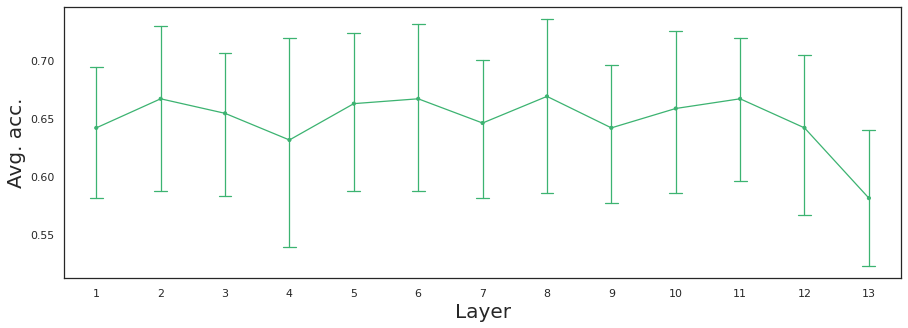

In [ ]:
import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 0.7})
plt.figure(figsize = (15,5))
ax = sns.pointplot(data = grand_acc, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Avg. acc.',size = 20)


### Regular Accuracy

In [ ]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
acc = [0]*6
for cat in range(6):
  tf.keras.backend.clear_session()

  print('Category of interest: ', categories[cat])
  train_it = np.concatenate((reg_train[cat],reg_train[cat + 6]))
  test_it = np.concatenate((data_test[cat],data_test[cat + 6]))
  print(train_it.shape,test_it.shape)


  #plot_model(model,show_shapes=True,expand_nested=True)
  #model.save_weights('vgg_w',save_format='h5')

  features_train = model.predict(train_it) 

  features_test = model.predict(test_it) 


  epochs = 30
  #train_data = np.load('features_train.npy')
  ntrain = 80
  train_data = features_train
  train_labels = to_categorical([0] * ntrain + [1]*ntrain)


  #test_data = np.load('features_test.npy')
  ntest = 40
  test_data = features_test
  test_labels = to_categorical([0] * ntest + [1]*ntest)



  es = EarlyStopping(monitor='loss', mode='min', verbose=1)

  history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 0, callbacks = [es])

  out = top_model.evaluate(test_data, test_labels)
  print(out)
  acc[cat] = out[1]
  #print('rounded test labels',pred)
np.mean(acc)

Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 3ms/step - loss: 0.7720 - accuracy: 0.6625
[0.771994948387146, 0.6625000238418579]
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)
Epoch 00009: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.8928 - accuracy: 0.6625
[0.8927855491638184, 0.6625000238418579]
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)
Epoch 00005: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.9496 - accuracy: 0.6375
[0.9496103525161743, 0.637499988079071]
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)
Epoch 00003: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 1.6490 - accuracy: 0.5875
[1.6489547491073608, 0.5874999761581421]
Category of interest:  Powered
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 3ms/step - loss: 0.7310 - accuracy: 

0.6458333333333334

### Layer wise plot

Text(0, 0.5, 'Performance Increase (%)')

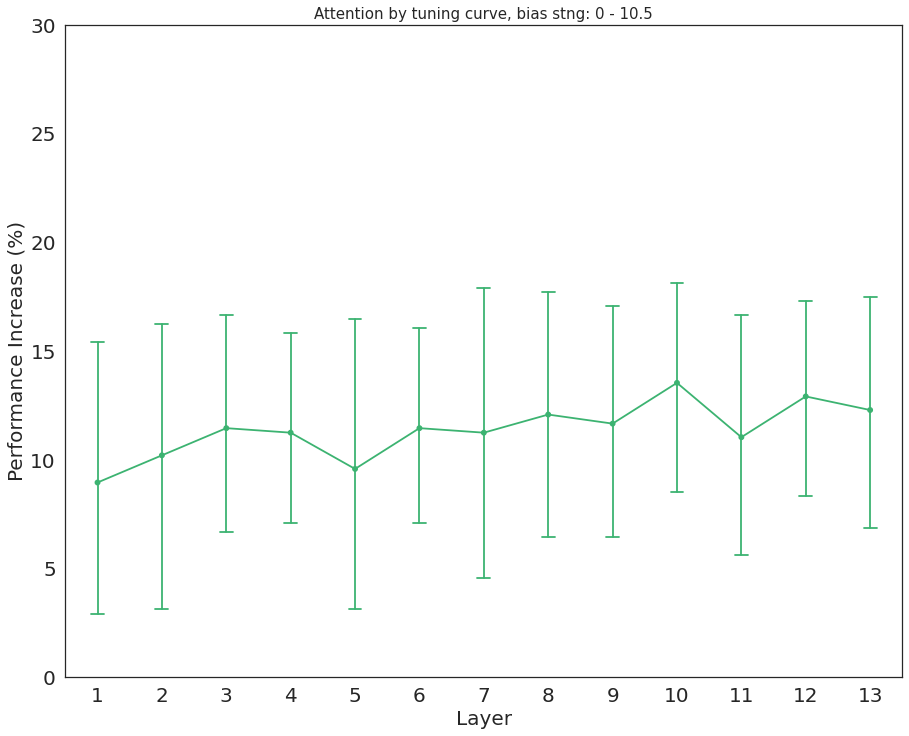

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.load('tun_accuracy_multi0.npy')
x = np.expand_dims(x,0)

for i in np.arange(1,5,1):
  temp = np.load('tun_accuracy_multi' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  x = np.vstack((x,temp))

'''
for i in np.arange(1,11,1):
  temp = np.load('tun_accuracy_new' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  x = np.vstack((x,temp))
'''

x = np.amax(x,0)

plt_data = np.zeros((6,13))
for i in range(6):
  for j in range(13):
    plt_data[i,j] = x[i,j] - acc[i]


import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 1})
plt.figure(figsize = (15,12))
ax = sns.pointplot(data = plt_data*100, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
                   
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14),size = 20)
plt.yticks(fontsize = 20)
plt.ylim(0,30)
plt.title('Attention by tuning curve, bias stng: 0 - 10.5',size = 15)
ax.set_ylabel('Performance Increase (%)',size = 20)

### Cateogory wise plot

In [ ]:
np.amax(gacc,0).T

array([[0.76249999, 0.82499999, 0.83749998, 0.75      , 0.72500002,
        0.76249999],
       [0.78750002, 0.73750001, 0.83749998, 0.76249999, 0.72500002,
        0.63749999],
       [0.72500002, 0.73750001, 0.83749998, 0.76249999, 0.76249999,
        0.625     ],
       [0.72500002, 0.71249998, 0.83749998, 0.76249999, 0.77499998,
        0.75      ],
       [0.75      , 0.72500002, 0.83749998, 0.76249999, 0.78750002,
        0.6875    ],
       [0.73750001, 0.71249998, 0.83749998, 0.82499999, 0.82499999,
        0.66250002],
       [0.76249999, 0.71249998, 0.83749998, 0.76249999, 0.71249998,
        0.66250002],
       [0.77499998, 0.75      , 0.83749998, 0.76249999, 0.80000001,
        0.71249998],
       [0.77499998, 0.71249998, 0.82499999, 0.86250001, 0.72500002,
        0.67500001],
       [0.80000001, 0.85000002, 0.82499999, 0.78750002, 0.75      ,
        0.72500002],
       [0.78750002, 0.73750001, 0.82499999, 0.76249999, 0.73750001,
        0.64999998],
       [0.78750002, 0

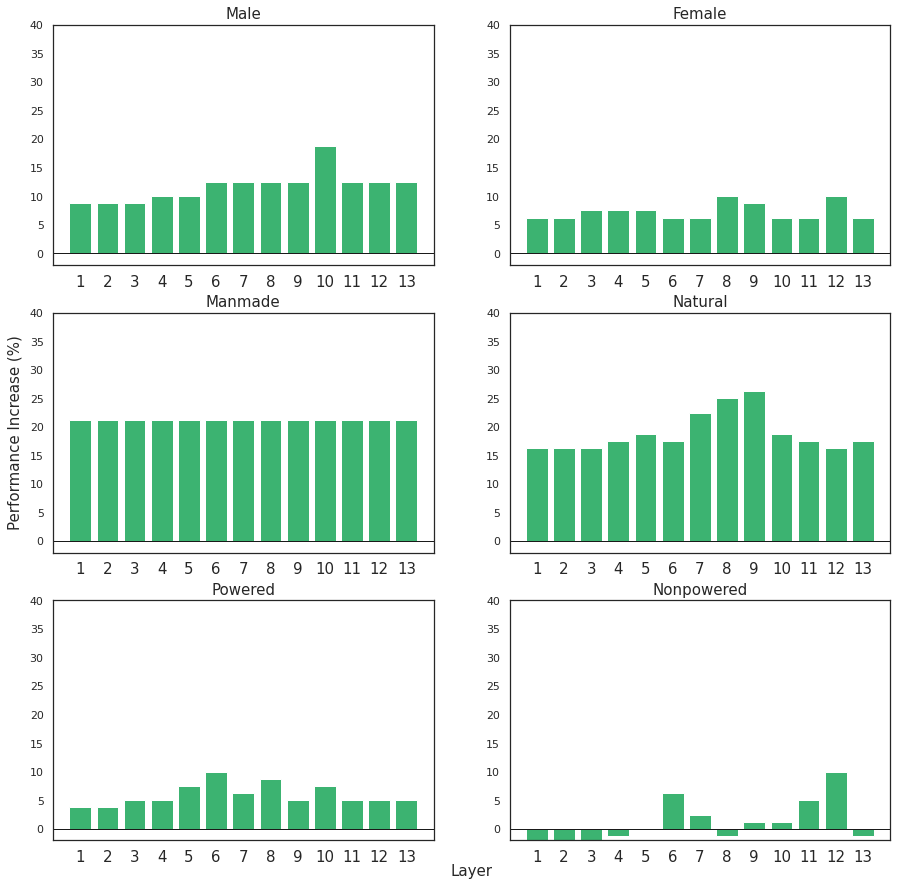

In [ ]:
gacc = np.load('tun_accuracy_multi0.npy')
gacc = np.expand_dims(gacc,0)

for i in np.arange(1,5,1):
  temp = np.load('tun_accuracy_multi' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  gacc = np.vstack((gacc,temp))
strngs = np.arange(0.5,5,1)

'''
for i in np.arange(1,11,1):
  temp = np.load('tun_accuracy_add' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  gacc = np.vstack((gacc,temp))
'''

strngs = np.concatenate((strngs,np.arange(1,6,1)))
y = np.amax(gacc,0).T


plt_data = np.zeros((13,6))
for i in range(13):
  for j in range(6):
    plt_data[i,j] = y[i,j] - acc[j]


import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 1})
layer = 0
f,axes = plt.subplots(3,2,figsize=(15,15))
f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Layer",size = 15)
plt.ylabel("Performance Increase (%)",size = 15)
for x in range(3):
  for y in range(2):
    axes[x,y].bar(x = np.arange(0,13),height = plt_data[:,layer]*100,color = 'mediumseagreen')
    axes[x,y].set_xticklabels(np.arange(1,14),size = 15)
    axes[x,y].set_xticks(np.arange(0,14))
    axes[x,y].set_title(categories[layer],size = 15)
    axes[x,y].set_ylim(-2,40)
    axes[x,y].set_xlim(-1,13)
    axes[x,y].hlines(y = 0,xmin= -1,xmax = 13)
    layer+=1
  